In [2]:
import re

def extract_number_from_brackets(s):
    match = re.search(r'\[(\d+)\]', s)
    if match:
        return int(match.group(1))
    return None

# Example usage
example_string = "rgbd_set.request[owl_keyword[-1]][i][\"boxes\"]"
number = extract_number_from_brackets(example_string)
print(number)  # Output will be the number inside the first pair of brackets

None


In [2]:
audio_model = whisper.load_model("base")


In [5]:
result = audio_model.transcribe("/root/catkin_ws/src/guide_dog/src/tmp/recording.wav")["text"]


In [6]:
result

' The birch canoes lid on the smooth planks. Glue the sheet to the dark blue background. It is easy to tell the depths of a well. These days the chicken leg is a rare dish. Rice is often served in round bowls. The juice of lemons makes fine punch. The box was thrown beside the park truck. The hogs are fed chopped corn and garbage. Four hours of study work faced us. A large size in stockings is hard to sell.'

In [27]:

image = PIL.Image.open("/world/NUS-Playground/images/truck.jpg")
text=["wheel"]
text_encodings = predictor.encode_text(text)
output = predictor.predict(image=image, text=text,text_encodings=text_encodings, threshold=0.1)

print(output)


OwlDecodeOutput(labels=tensor([0, 0, 0, 0], device='cuda:0'), scores=tensor([0.1605, 0.1840, 0.1247, 0.1109], device='cuda:0',
       grad_fn=<IndexBackward0>), boxes=tensor([[1386.0352,  546.3867, 1633.8867,  769.6289],
        [ 422.7539,  602.6367,  679.3945,  843.4570],
        [1239.2578,  686.1328, 1395.7031,  752.9297],
        [ 387.3779,  719.5312,  475.0488,  814.4531]], device='cuda:0'), input_indices=tensor([0, 0, 0, 0], device='cuda:0'))


In [30]:
print(output.boxes)

tensor([[1386.0352,  546.3867, 1633.8867,  769.6289],
        [ 422.7539,  602.6367,  679.3945,  843.4570],
        [1239.2578,  686.1328, 1395.7031,  752.9297],
        [ 387.3779,  719.5312,  475.0488,  814.4531]], device='cuda:0')


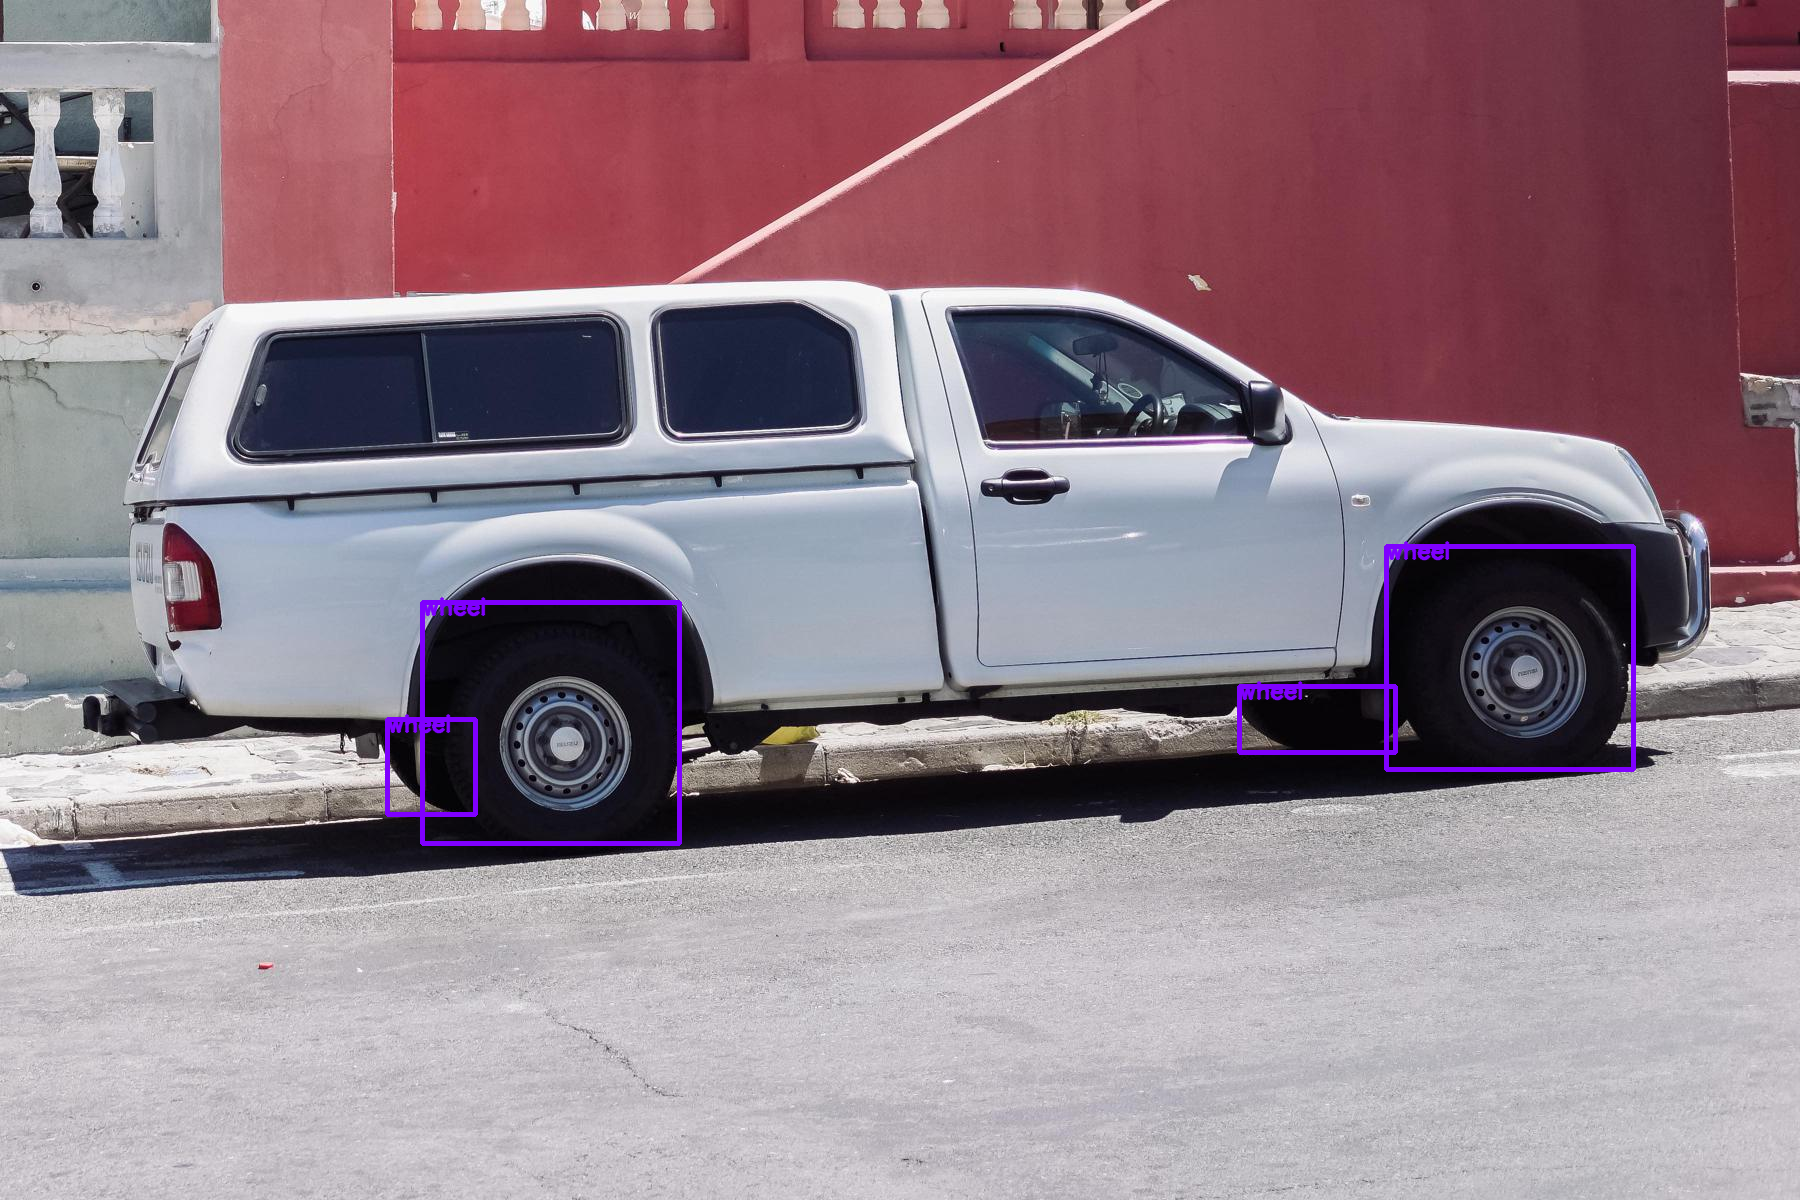

In [29]:
image = draw_owl_output(image, output, text=text, draw_text=True)
image.show()